In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
from tqdm import tqdm
import tensorflow as tf

In [2]:
#defining train data set
train_dir='aks/data'
Train_Data=tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=16,subset="training",target_size=(224,224),shuffle=False)


Found 385 images belonging to 2 classes.


In [3]:
list(Train_Data.class_indices.keys())

['ahmed_khairullah', 'ahmed_khaled']

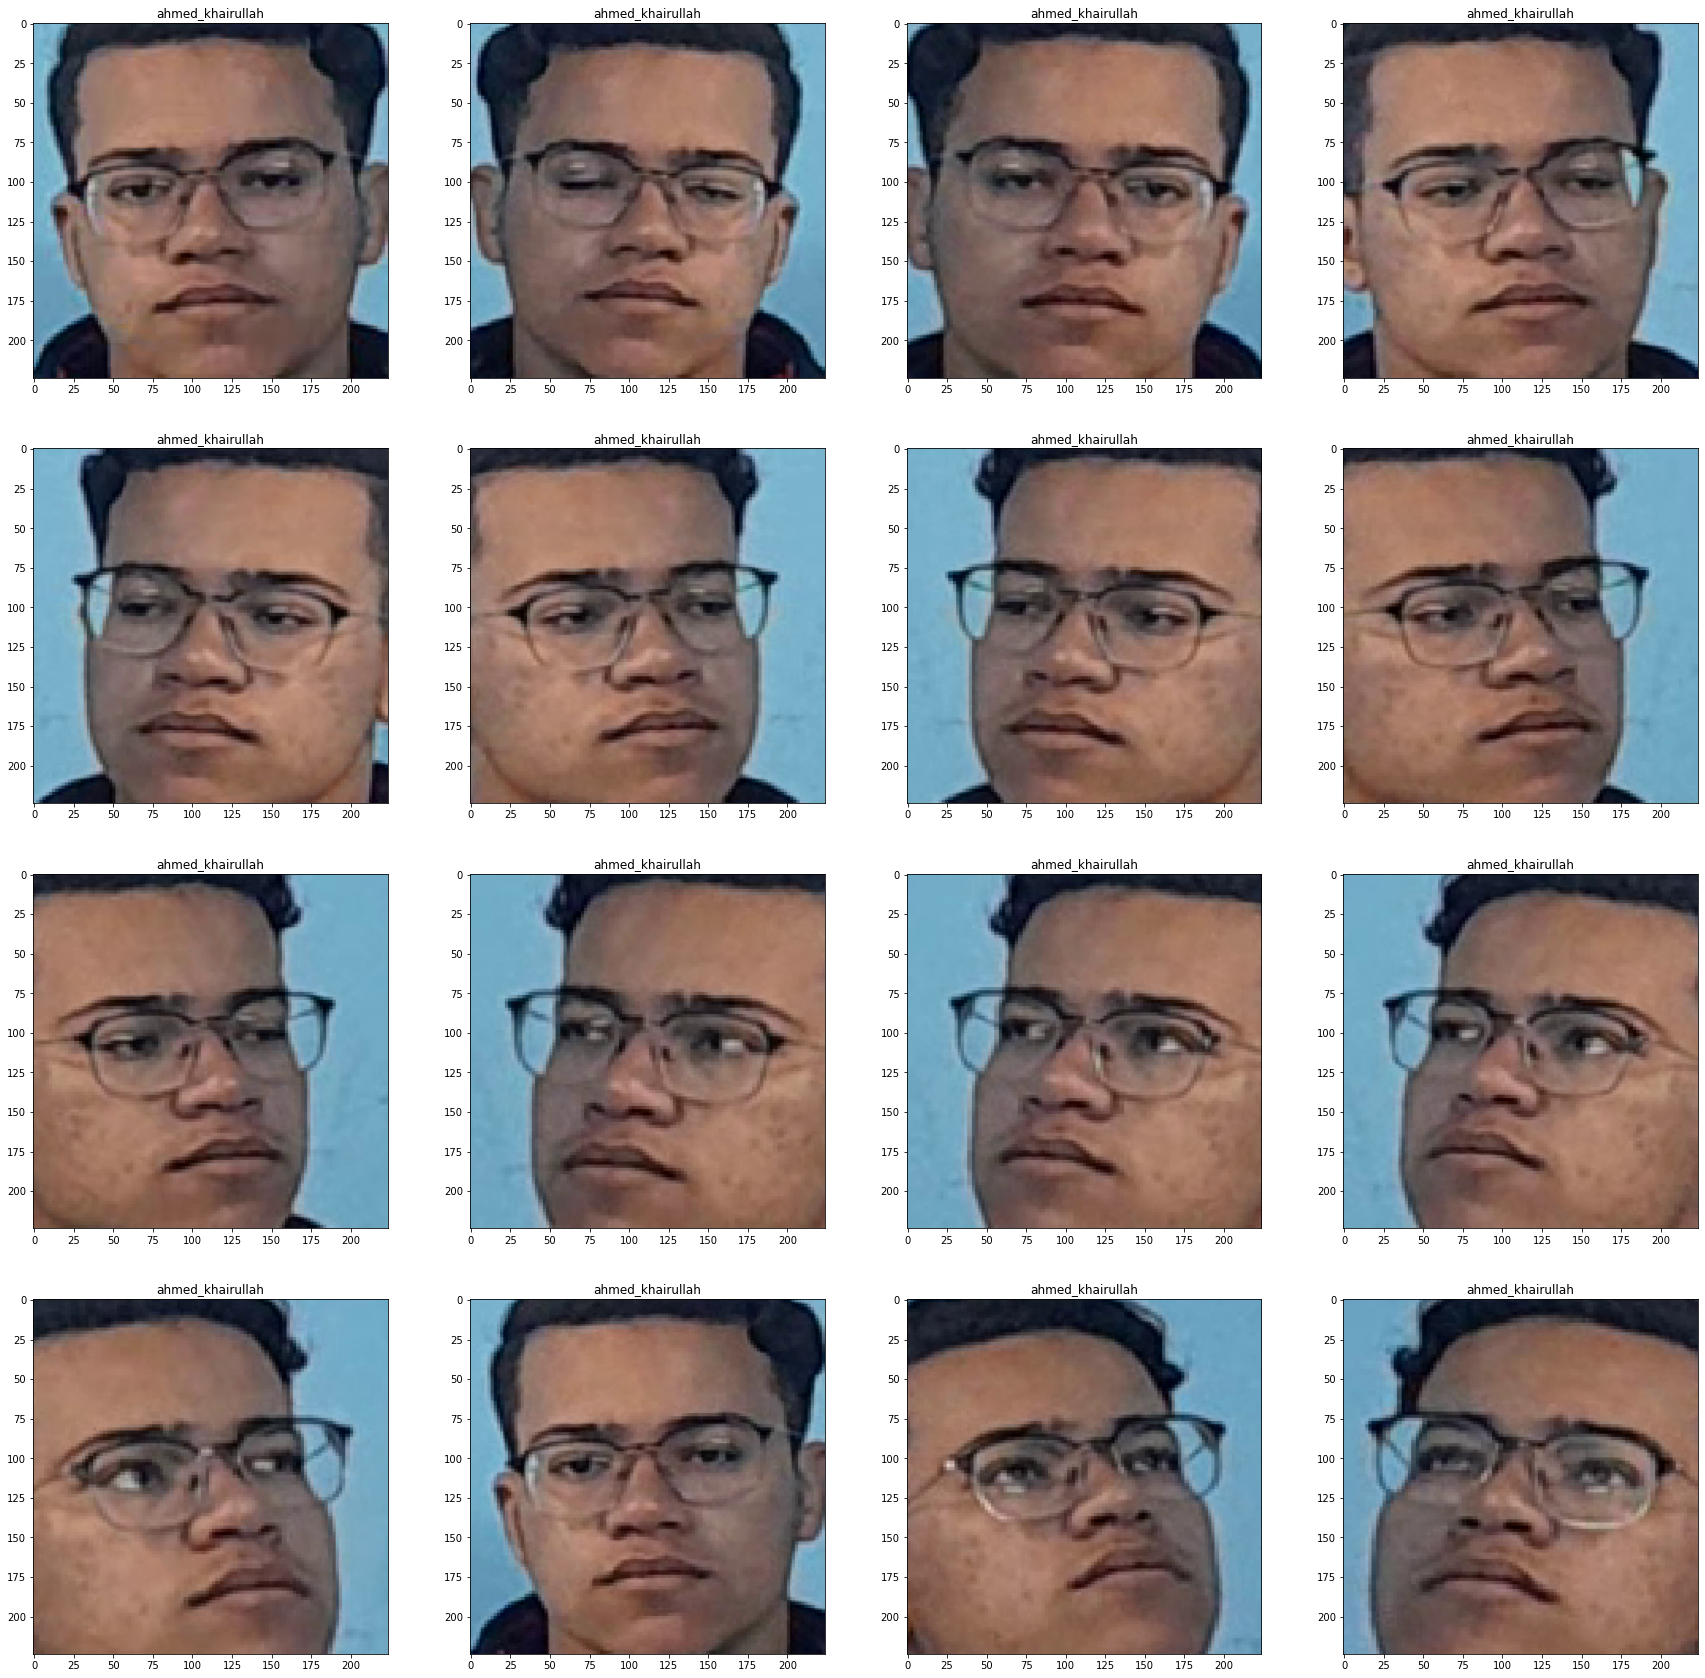

In [4]:
classes=list(Train_Data.class_indices.keys())
plt.figure(figsize=(30,30))
for X_batch, y_batch in Train_Data:
    # create a grid of 7x7 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [6]:
model = vgg_face()

model.load_weights('aks/vgg_face_weights.h5')

In [7]:
from tensorflow.keras.models import Model
model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)     

In [9]:
embedding_vector = model.predict(Train_Data,steps=len(Train_Data), verbose=1)

25/25 [==============================] - 60s 2s/step


In [10]:
y_train=Train_Data.labels

In [11]:
np.save('Xdata',embedding_vector)

In [12]:
np.save('ydata',y_train)

In [13]:
embedding_vector = np.load('Xdata.npy')
y_train = np.load('ydata.npy')

In [14]:
embedding_vector[0]

array([ 0.01543292, -0.00888819,  0.00754897, ..., -0.01627489,
        0.01918122,  0.00942735], dtype=float32)

In [15]:
y_train[0]

0

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(embedding_vector,y_train,test_size=0.1,shuffle=True, stratify=y_train,random_state=42)

In [17]:
from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train)

In [18]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [20]:
X_train.shape

(346, 100)

In [21]:
from sklearn.svm import SVC

clf = SVC(kernel='linear',C=2.,class_weight='balanced',decision_function_shape='ovo',probability=True)
clf.fit(X_train, y_train)

SVC(C=2.0, class_weight='balanced', decision_function_shape='ovo',
    kernel='linear', probability=True)

In [22]:
y_predict = clf.predict(X_test)

In [23]:
y_predict[:5]

array([1, 1, 0, 1, 1])

In [24]:
from joblib import dump
dump(scaler, 'scaler.joblib')
dump(pca, 'pca_model.joblib')
dump(clf, 'SVC.joblib') 

['SVC.joblib']

In [25]:
# Find the classification accuracy
from sklearn.metrics import accuracy_score
print(f'The Accuracy of VGGFace2 is {accuracy_score(y_test,y_predict)*100} %')

The Accuracy of VGGFace2 is 100.0 %


In [26]:
from numpy import expand_dims
from cv2 import resize,INTER_CUBIC
from tensorflow.keras.preprocessing.image import  img_to_array

def preprocess_image(img):
    img = img_to_array(img)
    img = img/255.0
    img = expand_dims(img, axis=0)
    return img

def Face_Recognition(roi,model,scaler,pca,clf):
    roi=resize(roi,dsize=(224,224),interpolation=INTER_CUBIC)
    roi=preprocess_image(roi)
    embedding_vector = model.predict(roi)[0]

    embedding_vector=scaler.transform(embedding_vector.reshape(1, -1))
    embedding_vector_pca = pca.transform(embedding_vector)
    result1 = clf.predict(embedding_vector_pca)[0]
    #print(result1)
    y_predict = clf.predict_proba(embedding_vector_pca)[0]
    #print(y_predict)
    
    result = np.where(y_predict > 0.8)[0]
    
    return result , y_predict

In [27]:
print((list(Train_Data.class_indices.keys())))

['ahmed_khairullah', 'ahmed_khaled']


In [ ]:
import cv2
import torch

fire = torch.hub.load('ultralytics/yolov5', 'custom', 
 path='fire.pt', force_reload=True)
weapon = torch.hub.load('ultralytics/yolov5', 'custom', 
 path='weapon.pt', force_reload=True)
mask = torch.hub.load('ultralytics/yolov5', 'custom', 
 path='mask.pt', force_reload=True)

In [ ]:
ress=[]
end=[]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import cv2
mtcnn = MTCNN(image_size=160, margin=14, min_face_size=20,device='cpu', post_process=False)

cap=cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1200)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1600)
classes = {'ahmed_khairullah': 0, 'ahmed_khaled': 1}


def ImageClass(n):
    for x , y in classes.items():
        if n == y :
            return x
size = (1600, 1200)

result_video = cv2.VideoWriter('ahmed.mp4', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
font = cv2.FONT_HERSHEY_SIMPLEX     
fontScale = 1
color = (255, 0, 0)
thickness = 2
other = 0
while True :
    ret, frame = cap.read()
    if not ret:
        break  
    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame=cv2.resize(frame,(1600,1200),interpolation=cv2.INTER_CUBIC)
    frame=cv2.GaussianBlur(frame, ksize=(3,3), sigmaX=0)
    frame_face = frame.copy()
    frame_face=cv2.resize(frame_face,(640,640),interpolation=cv2.INTER_CUBIC)
    boxes, probs = mtcnn.detect(frame_face, landmarks=False)
    res_f = fire(frame, size=640)  
    re_f=res_f.pandas().xyxy[0]
    for i in range (len(re_f)) :
        xmin,ymin,xmax,ymax,confidence,_,_=re_f.iloc[i,:]
        xmin,ymin,xmax,ymax=int(xmin),int(ymin),int(xmax),int(ymax)
        if confidence > 0.6 :
            cv2.rectangle(frame, (xmin , ymin), (xmax , ymax), (255, 0, 0), 2)
            cv2.putText(frame, str(res.name[i]), (xmin , ymin), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA) 
            cv2.putText(frame, str(round(confidence,2)), (xmin+50 , ymin), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA) 
            ress.append(4)

    if  not probs.all() == None and probs.all()> 0.6 :
        for x1,y1,x2,y2 in boxes :
            x1,x2,y1,y2=int(x1) * 1600 //640,int(x2) * 1600 //640,int(y1) * 1200 //640,int(y2) * 1200 //640
            roi=frame[y1:y2,x1:x2]
            result , y_predict=Face_Recognition(roi,model,scaler,pca,clf)
            if len(result) > 1 :
                name=ImageClass(result[1])
                cv2.putText(frame, name , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA)
                cv2.putText(frame, str(np.round(y_predict[result[0]],2)) , (x2,y1-10), font,fontScale, color, thickness, cv2.LINE_AA)
                ress.append(0)
            elif  len(result)== 0 :
                name='Other'
                roi=cv2.cvtColor(roi,cv2.COLOR_RGB2BGR)  
                cv2.imwrite(f'Pic{other}.png', roi)
                cv2.putText(frame, name , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA)
                other = other + 1
                ress.append(1)
            
                res_w = weapon(frame, size=640)  
                re_w=res_w.pandas().xyxy[0]
                for i in range (len(re_w)) :
                    xmin,ymin,xmax,ymax,confidence,_,_=re_w.iloc[i,:]
                    xmin,ymin,xmax,ymax=int(xmin),int(ymin),int(xmax),int(ymax)
                    if confidence > 0.6 :
                        cv2.rectangle(frame, (xmin , ymin), (xmax , ymax), (255, 0, 0), 2)
                        cv2.putText(frame, str(res.name[i]), (xmin , ymin), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA) 
                        cv2.putText(frame, str(round(confidence,2)), (xmin+50 , ymin), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA) 
                        ress.append(2)
                res_m = mask(frame, size=640)  
                re_m=res_m.pandas().xyxy[0]
                for i in range (len(re_m)) :
                    xmin,ymin,xmax,ymax,confidence,_,_=re_m.iloc[i,:]
                    xmin,ymin,xmax,ymax=int(xmin),int(ymin),int(xmax),int(ymax)
                    if confidence > 0.6 :
                        cv2.rectangle(frame, (xmin , ymin), (xmax , ymax), (255, 0, 0), 2)
                        cv2.putText(frame, str(res.name[i]), (xmin , ymin), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA) 
                        cv2.putText(frame, str(round(confidence,2)), (xmin+50 , ymin), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0), 2, cv2.LINE_AA) 
                        ress.append(3)
                
                
            else :
                cv2.putText(frame, ImageClass(result) , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA)
                cv2.putText(frame, str(np.round(y_predict[result[0]],2)) , (x2,y1-10), font,fontScale, color, thickness, cv2.LINE_AA)
                ress.append(0)
                
            for x in ress[:]:
                if x==0:
                    print("no problem")
            
                elif x==4:
                    print("fire")
                elif x==1:
                    end.append("unknown_person")
                elif x==2:
                    end.append("gun_or_knife")
                elif x==3:
                    e      nd.append("masked_person")
            
            if len(end)!=0:
                print(end)       
            ress.clear()
            end.clear()
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    frame=cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)             
    result_video.write(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
result_video.release()
cv2.destroyAllWindows() 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import cv2 
mtcnn = MTCNN(image_size=160, margin=14, min_face_size=20,device='cpu', post_process=False)

cap=cv2.VideoCapture('ahmeed.mp4')
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1500)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1800)
classes = {'ahmed_khairullah': 0, 'ahmed_khaled': 1}


def ImageClass(n):
    for x , y in classes.items():
        if n == y :
            return x
size = (1600, 1200)

result_video = cv2.VideoWriter('ahmeddd.mp4', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
font = cv2.FONT_HERSHEY_SIMPLEX     
fontScale = 1
color = (255, 0, 0)
thickness = 2
other = 0
while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break  
    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame=cv2.resize(frame,(1600,1200),interpolation=cv2.INTER_CUBIC)
    frame=cv2.GaussianBlur(frame, ksize=(3,3), sigmaX=0)
    frame_face = frame.copy()
    frame_face=cv2.resize(frame_face,(640,640),interpolation=cv2.INTER_CUBIC)
    boxes, probs = mtcnn.detect(frame_face, landmarks=False)

    if  not probs.all() == None and probs.all()> 0.6 :
        for x1,y1,x2,y2 in boxes :
            x1,x2,y1,y2=int(x1) * 1600 //640,int(x2) * 1600 //640,int(y1) * 1200 //640,int(y2) * 1200 //640
            roi=frame[y1:y2,x1:x2]
            result , y_predict=Face_Recognition(roi,model,scaler,pca,clf)
            if len(result) > 1 :
                cv2.putText(frame, ImageClass(result[0]) , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA)
                cv2.putText(frame, str(np.round(y_predict[result[0]],2)) , (x2,y1-10), font,fontScale, color, thickness, cv2.LINE_AA)
            elif  len(result)== 0 :
                roi=cv2.cvtColor(roi,cv2.COLOR_RGB2BGR)  
                cv2.imwrite(f'Pic{other}.png', roi)
                cv2.putText(frame, 'Other' , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA)
                other = other + 1
            else :
                cv2.putText(frame, ImageClass(result) , (x1-5,y1-5), font,fontScale, color, thickness, cv2.LINE_AA)
                cv2.putText(frame, str(np.round(y_predict[result[0]],2)) , (x2,y1-10), font,fontScale, color, thickness, cv2.LINE_AA)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
    #else:
    #    continue
    frame=cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)             
    result_video.write(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
result_video.release()
cv2.destroyAllWindows() 
